In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import emcee
import pandas as pd

In [138]:
us_confirmed = pd.read_csv('/Users/kulkarniad/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
us_deaths = pd.read_csv('/Users/kulkarniad/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

In [139]:
def get_us_data(state):
    df = us_confirmed[us_confirmed['Province_State'] == state]
    confirmed = df.sum(axis=0)
    confirmed = confirmed[11:]  # skip metadata
    confirmed = pd.DataFrame(confirmed,columns=['confirmed'])
    
    df = us_deaths[us_deaths['Province_State'] == state]
    deaths = df.sum(axis=0)
    deaths = deaths[12:]  # skip metadata
    deaths = pd.DataFrame(deaths,columns=['deaths'])
    
    df = pd.concat([confirmed,deaths], axis=1)
    
    df = df[(df.T != 0).any()] # start at the first confirmed case
    return df

In [140]:
colorado = get_us_data('Colorado')

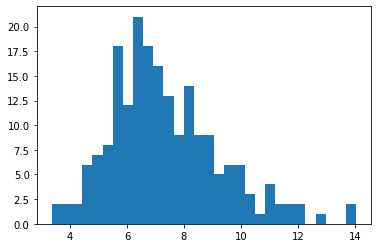

In [141]:
s, loc, scale = 0.25,0,7
gamma = stats.lognorm.rvs(s,loc,scale,size=200)
gamma = 1/gamma
plt.hist(1/gamma,bins=30)
plt.show()

In [142]:
r0_grid = np.linspace(0,5,num=1000)

In [143]:
# predict new cases given yesterday's cases,gamma,effective R
def newcases(yesterday_cases,gamma,R):
    out = yesterday_cases
    out *= np.e**(gamma*(R-1))
    return out



In [144]:
def r0_lhood(r0,gamma,yest_nc,today_nc):
    prediction = newcases(yest_nc,gamma,r0)
    lhood = stats.poisson.logpmf(today_nc,prediction)
    return lhood

Makes sense, Now do it for colorado....

In [145]:
def bayes_update(confirmed_vals,gamma,sigma=0.3):
    # Compute likelihoods
    likehoods = []
    for i in range(len(colorado)-1):
        yesterday = colorado.confirmed.values[i]
        today = colorado.confirmed.values[i+1]
        pmf = np.e**r0_lhood(r0_grid,gamma,yesterday,today)
        pmf /= np.sum(pmf)
        likehoods.append(pmf)
    likehoods = np.array(likehoods)
    
    # Process matrix governs random perturbations to R0 over time
    process_matrix = stats.norm(loc=r0_grid,
                                  scale=sigma
                                 ).pdf(r0_grid[:, None]) 

    # Now compute posteriors using previous posterior as new prior

    posteriors = []
    prior = np.ones(len(r0_grid))/len(r0_grid)

    for i in range(len(colorado) - 1):
        posterior = likehoods[i] * prior
        posterior /= np.sum(posterior)
        posteriors.append(posterior)    
        prior = process_matrix @ posterior

    posteriors = np.array(posteriors)
    
    return likehoods,posteriors

In [153]:
# Now take into effects for all gammas:
current_posterior = np.zeros(len(r0_grid))
current_likehood = np.zeros(len(r0_grid))

for g in gamma:
    l,p = bayes_update(colorado.confirmed.values,g)
    # only keep latest estimate of likelihood and posterior
    current_posterior += l[-1]
    current_posterior += p[-1]


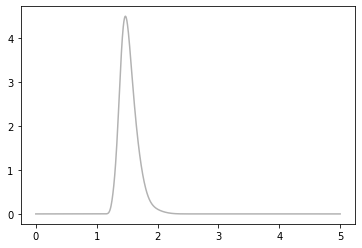

In [156]:
plt.plot(r0_grid,final_posterior,alpha = 0.3,color = 'black')

Now make extrapolations

In [ ]:
# predict new cases given yesterday's cases,gamma,effective R
def newcases(yesterday_cases,gamma,R):
    out = yesterday_cases
    out *= np.e**(gamma*(R-1))
    return out



In [166]:
colorado.values[-1,0]

10473

In [167]:
newcases(colorado.values[-1,0],1/stats.lognorm.rvs(s,loc,scale),0.9)

10276.125112387848